# 設定

In [287]:
import os
from dotenv import load_dotenv
import time
load_dotenv()

BITMART_API_KEY = os.getenv("BITMART_API_KEY")
BITMART_SECRET_KEY = os.getenv("BITMART_SECRET_KEY")
BITMART_MEMO = os.getenv("BITMART_MEMO")
TOPONE_API_KEY = os.getenv("TOPONE_API_KEY")
TOPONE_SECRET_KEY = os.getenv("TOPONE_SECRET_KEY")

# bitmart 客戶端


In [288]:
import logging
import time
import pandas as pd
from bitmart.api_contract import APIContract
from bitmart.lib.cloud_exceptions import APIException
import math
import uuid
import datetime
import requests
from datetime import timedelta,datetime

# 設定 logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger("bitmart").setLevel(logging.ERROR)
logging.getLogger("urllib3").setLevel(logging.ERROR)

class BitmartClient:
    def __init__(self, api_key: str, secret_key: str, memo: str):
        self.futuresAPI = APIContract(api_key=api_key, secret_key=secret_key, memo=memo)
        self.logger = logging.getLogger(__name__)
        self.BASE_URL = "https://api-cloud-v2.bitmart.com"
    
    def _time_to_timestamp(self, t):
        """將 datetime 或 timestamp 轉成秒級 timestamp"""
        if t is None:
            return int(time.time())
        elif isinstance(t, (int, float)):
            return int(t)
        elif isinstance(t, datetime):
            return int(t.timestamp())
        else:
            raise ValueError("❌ start_time/end_time 必須是 datetime 或 timestamp 或 None")

    def get_balance(self):
        try:
            response = self.futuresAPI.get_assets_detail()[0]
            usdt_asset = next((asset for asset in response['data'] if asset['currency'] == 'USDT'), None)
            if usdt_asset:
                return float(usdt_asset['available_balance'])
            else:
                self.logger.info("USDT asset not found")
                return None
        except APIException as error:
            self.logger.error(f"Found error. status: {error.status_code}, error message: {error.response}")
            return None
    
    def get_current_price(self, symbol: str):
        try:
            depth_data = self.futuresAPI.get_depth(symbol)[0]['data']
            if depth_data and depth_data.get('bids') and depth_data.get('asks'):
                best_bid = float(depth_data['bids'][0][0])
                best_ask = float(depth_data['asks'][0][0])
                return (best_bid + best_ask) / 2
            else:
                self.logger.error(f"Could not get bids/asks from depth data.")
                return None
        except (APIException, IndexError, KeyError) as error:
            self.logger.error(f"Failed to get depth: {error}")
            return None
    
    def get_kline_data(self, symbol: str, step: str = "15m", start_time=None, end_time=None):
        """
        取得 BitMart K 線資料
        :param symbol: 交易對 (例如 'ETHUSDT')
        :param step: K線時間粒度，可用 1m,3m,5m,15m,30m,1h,2h,4h,6h,12h,1d,3d,1w
        :param start_time: 起始時間（datetime 或 timestamp 或 None）
        :param end_time: 結束時間（datetime 或 timestamp 或 None）
        :return: pandas.DataFrame
        """

        # step 映射表（BitMart 需要整數分鐘）
        step_map = {
            "1m": 1, "3m": 3, "5m": 5, "15m": 15, "30m": 30,
            "1h": 60, "2h": 120, "4h": 240, "6h": 360, "12h": 720,
            "1d": 1440, "3d": 4320, "1w": 10080
        }

        if step not in step_map:
            raise ValueError(f"❌ 不支援的 step 格式: {step}")

        step_value = step_map[step]
        end_ts = self._time_to_timestamp(end_time)
        start_ts = self._time_to_timestamp(start_time) if start_time else end_ts - step_value * 60 * 500  # 最多 500 根

        url = f"{self.BASE_URL}/contract/public/kline"
        params = {
            "symbol": symbol,
            "step": step_value,
            "start_time": start_ts,
            "end_time": end_ts
        }

        try:
            r = requests.get(url, params=params)
            data = r.json()
            if data.get("code") != 1000:
                raise Exception(f"❌ API 回傳錯誤: {data}")

            df = pd.DataFrame(data["data"])
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
            df = df.rename(columns={
                "open_price": "open",
                "close_price": "close",
                "high_price": "high",
                "low_price": "low",
                "volume": "volume"
            })
            df = df[["timestamp", "open", "high", "low", "close", "volume"]]
            df = df.astype({
                "open": float, "high": float, "low": float,
                "close": float, "volume": float
            })
            return df.sort_values("timestamp").reset_index(drop=True)

        except Exception as e:
            print(f"🚨 取得 K 線資料失敗: {e}")
            return pd.DataFrame()
    
    def _get_price_precision(self, precision_str: str) -> int:
        """計算價格精度"""
        return len(precision_str.split('.')[1]) if '.' in precision_str else 0

    def _set_leverage(self, symbol: str, leverage: int):
        """設置逐倉杠桿"""
        try:
            self.futuresAPI.post_submit_leverage(
                contract_symbol=symbol,
                leverage=str(leverage),
                open_type="isolated"
            )
        except APIException as e:
            self.logger.warning(f"Failed to set leverage for {symbol}: {e}")
    
    def place_order(self, symbol: str, side: str, margin: float, leverage: int,
                    tp_price: float = None, sl_price: float = None):
        """
        下單函數 (兼容 SDK，固定逐倉，可選 TP/SL)
        :param symbol: 交易對
        :param side: 'long' 開多 或 'short' 開空
        :param margin: 使用保證金
        :param leverage: 杠桿倍數
        :param tp_price: 止盈價 (可選)
        :param sl_price: 止損價 (可選)
        :return: API 回應
        """

        # 1. 獲取當前價格
        current_price = self.get_current_price(symbol)
        if not current_price:
            self.logger.error(f"Cannot fetch current price for {symbol}")
            return None

        # 2. 獲取合約詳情
        try:
            details_data = self.futuresAPI.get_details(symbol)[0]['data']
            symbol_details = details_data['symbols'][0]
            contract_size = float(symbol_details['contract_size'])

            precision_str = symbol_details['price_precision']
            price_precision = len(precision_str.split('.')[1]) if '.' in precision_str else 0
        except (Exception) as e:
            self.logger.error(f"Could not get contract details: {e}")
            return None

        # 3. 計算下單數量
        size = int((margin * leverage) / (current_price * contract_size))
        if size <= 0:
            self.logger.error(f"Calculated size <= 0, cannot place order")
            return None

        # 4. 設置杠桿
        try:
            self.futuresAPI.post_submit_leverage(
                contract_symbol=symbol,
                leverage=str(leverage),
                open_type="isolated"
            )
        except Exception as e:
            self.logger.error(f"Failed to set leverage: {e}")

        # 5. 判斷下單方向
        side_map = {'long': 1, 'short': 4}  # 1=buy_open_long, 4=sell_open_short
        order_side = side_map.get(side.lower())
        if not order_side:
            self.logger.error(f"Invalid side: {side}")
            return None

        # 6. 四捨五入 TP/SL（如果有傳）
        payload_kwargs = {}
        if tp_price is not None:
            payload_kwargs['preset_take_profit_price'] = str(round(tp_price, price_precision))
        if sl_price is not None:
            payload_kwargs['preset_stop_loss_price'] = str(round(sl_price, price_precision))

        # 7. 發送下單請求
        try:
            response = self.futuresAPI.post_submit_order(
                contract_symbol=symbol,
                type="market",
                side=order_side,
                leverage=str(leverage),
                open_type="isolated",
                size=size,
                **payload_kwargs
            )
            return response
        except Exception as e:
            self.logger.error(f"Failed to submit order: {e}")
            return None
    
    def get_position(self, symbol: str):
        try:
            position_response = self.futuresAPI.get_position(symbol)
            positions = position_response[0]['data']
            for position in positions:
                if position['symbol'] == symbol:
                    return position
            self.logger.info(f"No open position found for {symbol}.")
            return None
        except (APIException, IndexError, KeyError) as e:
            self.logger.error(f"Failed to get position: {e}")
            return None

    
    def close_position(self, symbol: str):
        position = self.get_position(symbol)
        if not position:
            self.logger.info(f"No open position found for {symbol}.")
            return None

        position_type = position['position_type']
        current_amount = int(position['current_amount'])

        if current_amount == 0:
            self.logger.info(f"Position for {symbol} has size 0, nothing to close.")
            return None

        close_side = 0
        if position_type == 1: # Long position
            close_side = 3 # sell_close_long
        elif position_type == 2: # Short position (assuming it's 2, based on buy_close_short)
            close_side = 2 # buy_close_short
        else:
            self.logger.error(f"Unknown position type: {position_type}")
            return None

        try:
            leverage = position['leverage']
            open_type = position['margin_type'].lower()

            response = self.futuresAPI.post_submit_order(
                contract_symbol=symbol,
                type="market",
                side=close_side,
                size=current_amount,
                leverage=leverage,
                open_type=open_type
            )
            return response
        except (APIException, KeyError) as error:
            self.logger.error(f"Failed to close position: {error}")
            return None


# 測試bitmart客戶端功能

In [289]:
# 初始化 BitmartClient
bitmart_client = BitmartClient(BITMART_API_KEY, BITMART_SECRET_KEY, BITMART_MEMO)
# 查詢 K線
end_time = datetime.now()
start_time = datetime.now() - timedelta(days=4)
kline = bitmart_client.get_kline_data('ETHUSDT', "15m", start_time, end_time)
print("📊 K線資料:")
display(kline)
balance = bitmart_client.get_balance()
print("💰 可用餘額:", balance)
current_price = bitmart_client.get_current_price('ETHUSDT')
print("💰 當前價格:", current_price)
open_response = bitmart_client.place_order(
    symbol='ETHUSDT',
    side='long',
    margin=10,
    leverage=5,
    tp_price=current_price * 1.02,
    sl_price=current_price * 0.98   
)
print("📈 開倉回應:", open_response )
position = bitmart_client.get_position('ETHUSDT')
print("📄 目前倉位:", position)
time.sleep(5)
close_response = bitmart_client.close_position('ETHUSDT')
print("📤 關倉回應:", close_response )

📊 K線資料:


,timestamp,open,high,low,close,volume
0,2025-11-01 09:45:00,3874.91,3876.16,3873.22,3873.89,990054.0
1,2025-11-01 10:00:00,3873.90,3878.75,3870.43,3871.68,5205056.0
2,2025-11-01 10:15:00,3871.68,3875.13,3871.20,3872.48,4504910.0
3,2025-11-01 10:30:00,3872.48,3878.22,3871.71,3877.69,3017358.0
4,2025-11-01 10:45:00,3877.69,3880.44,3873.86,3875.00,3775404.0
...,...,...,...,...,...,...
380,2025-11-05 08:45:00,3294.88,3307.06,3281.00,3299.48,25958810.0
381,2025-11-05 09:00:00,3299.48,3320.61,3294.55,3303.93,25360134.0
382,2025-11-05 09:15:00,3303.94,3310.59,3291.99,3308.08,19037020.0
383,2025-11-05 09:30:00,3308.08,3310.66,3293.11,3305.00,15426058.0


💰 可用餘額: 52.285450134269276
💰 當前價格: 3305.505
💰 當前價格: 3305.505
📈 開倉回應: ({'code': 1000, 'message': 'Ok', 'data': {'order_id': 3000237110989391, 'price': 'market price'}, 'trace': '44b81762-b556-4f9c-9635-cdd1541fa300'}, {'Remaining': '1', 'Limit': '24', 'Reset': '2', 'Mode': 'KEY'})
📄 目前倉位: {'symbol': 'ETHUSDT', 'leverage': '5', 'timestamp': 1762336412668, 'current_fee': '0.0000402', 'open_timestamp': 1762336412620, 'current_value': '49.57965', 'mark_price': '3305.59473643', 'position_value': '49.57965', 'position_cross': '9.94567779', 'maintenance_margin': '0.123959802616125', 'close_vol': '0', 'close_avg_price': '0', 'open_avg_price': '3305.31', 'entry_price': '3305.31', 'current_amount': '15', 'unrealized_value': '0', 'realized_value': '-0.02974779', 'position_type': 1, 'margin_type': 'Isolated', 'mark_value': '49.58392104645', 'account': 'futures', 'position_mode': 'hedge_mode'}
📈 開倉回應: ({'code': 1000, 'message': 'Ok', 'data': {'order_id': 3000237110989391, 'price': 'market price'}, '

# topone客戶端

In [290]:
import time
import hashlib
import requests
import logging
import json 

class TopOneClient:
    def __init__(self, api_key: str, secret_key: str, memo: str = None):
        self.api_key = api_key
        self.secret_key = secret_key
        self.memo = memo
        self.base_url = "https://openapi.top.one"
        self.logger = logging.getLogger(__name__)

    def _get_signed_headers(self, method, path):
        timestamp = str(int(time.time() * 1000))
        
        signature_payload = f"Method={method.upper()}&Path={path}&Timestamp={timestamp}&Secret={self.secret_key}"

        signature = hashlib.sha256(signature_payload.encode('utf-8')).hexdigest()

        return {
            "X-Time": timestamp,
            "X-Openapi-Key": self.api_key,
            "X-Openapi-Sign": signature,
            "Content-Type": "application/json"
        }

    def get_balance(self):
        path = "/api/v1/balance"
        method = "GET"
        
        headers = self._get_signed_headers(method, path)

        try:
            response = requests.get(self.base_url + path, headers=headers)
            response.raise_for_status()
            data = response.json()

            if data.get("status") and data.get("status").get("error") is None:
                trading_account = data.get("data", {}).get("trading", [])
                usdt_asset = next((asset for asset in trading_account if asset.get('code') == 'USDT'), None)
                if usdt_asset and 'available' in usdt_asset:
                    return float(usdt_asset['available'])
                else:
                    self.logger.info("USDT asset not found in trading account.")
                    return 0.0
            else:
                message = data.get("status", {}).get("messages", "Unknown error")
                self.logger.error(f"API error: {message}")
                return None

        except requests.exceptions.RequestException as e:
            self.logger.error(f"Request failed: {e}")
            return None
        except ValueError: # Catches JSON decoding errors
            self.logger.error("Failed to decode JSON response.")
            return None

    def place_order(self, symbol: str, side: str, margin: float, leverage: int, tp_price: float, sl_price: float):
        path = "/fapi/v1/create-order"
        method = "POST"

        headers = self._get_signed_headers(method, path)

        if side.lower() == 'long':
            api_side = "buy"
            api_position_side = "long"
        elif side.lower() == 'short':
            api_side = "sell"
            api_position_side = "short"
        else:
            self.logger.error(f"Invalid side: {side}. Must be 'long' or 'short'.")
            return None

        payload = {
            "pair": symbol,
            "side": api_side,
            "position_side": api_position_side,
            "leverage": leverage,
            "margin_mode": 1, #逐倉
            "margin": str(margin),
            "take_profit_price": str(tp_price),
            "stop_loss_price": str(sl_price),
        }

        try:
            response = requests.post(self.base_url + path, headers=headers, data=json.dumps(payload))
            response.raise_for_status()
            data = response.json()

            if data.get("status") and data.get("status").get("error") is None:
                return data
            else:
                message = data.get("status", {}).get("messages", "Unknown error")
                self.logger.error(f"API error: {message}")
                return None

        except requests.exceptions.RequestException as e:
            self.logger.error(f"Request failed: {e}")
            return None
        except ValueError: 
            self.logger.error("Failed to decode JSON response.")
            return None

    def get_open_positions(self, symbol: str = None):
        path = "/fapi/v1/position"
        method = "GET"
        
        headers = self._get_signed_headers(method, path)
        params = {"status": 1} # Filter for open positions

        if symbol:
            params["pair"] = symbol

        try:
            response = requests.get(self.base_url + path, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()

            if data.get("status") and data.get("status").get("error") is None:
                return data.get("data", {}).get("list", [])
            else:
                message = data.get("status", {}).get("messages", "Unknown error")
                self.logger.error(f"API error getting open positions: {message}")
                return None
        except requests.exceptions.RequestException as e:
            self.logger.error(f"Request failed getting open positions: {e}")
            return None
        except ValueError:
            self.logger.error("Failed to decode JSON response getting open positions.")
            return None

    def get_position(self, symbol: str):
        """Get position for specific symbol (compatible with BitmartClient.get_position)"""
        try:
            positions = self.get_open_positions(symbol)
            if positions and len(positions) > 0:
                position = positions[0]
                #self.logger.info(f"Raw position data from get_open_positions for {symbol}: {position}")
                return {
                    'symbol': position.get('pair', symbol),
                    'size': position.get('quantity', '0'),
                    'side': position.get('side', None),  # TopOne uses 'side' field
                    'position_id': position.get('position_id'),
                    'entry_price': position.get('open_price', '0'),
                    'unrealized_pnl': position.get('unrealized_pnl', '0')
                }
            else:
                self.logger.info(f"No open position found for {symbol}.")
                return None
        except Exception as e:
            self.logger.error(f"Failed to get position for {symbol}: {e}")
            return None

    def close_position(self, symbol: str):
        open_positions = self.get_open_positions(symbol)
        if not open_positions:
            self.logger.info(f"No open positions found for {symbol}.")
            return None

        results = []
        for position in open_positions:
            position_id = position['position_id']
            quantity = position['quantity'] 

            path = "/fapi/v1/close"
            method = "POST"
            headers = self._get_signed_headers(method, path)
            payload = {
                "position_id": position_id,
                "quantity": quantity 
            }

            try:
                response = requests.post(self.base_url + path, headers=headers, data=json.dumps(payload))
                response.raise_for_status()
                data = response.json()

                if data.get("status") and data.get("status").get("error") is None:
                    self.logger.info(f"Position {position_id} closed successfully: {data}")
                    results.append({"position_id": position_id, "status": "success", "response": data})
                else:
                    message = data.get("status", {}).get("messages", "Unknown error")
                    self.logger.error(f"API error closing position {position_id}: {message}")
                    results.append({"position_id": position_id, "status": "failed", "message": message})
            except requests.exceptions.RequestException as e:
                self.logger.error(f"Request failed closing position {position_id}: {e}")
                results.append({"position_id": position_id, "status": "failed", "message": str(e)})
            except ValueError:
                self.logger.error(f"Failed to decode JSON response closing position {position_id}.")
                results.append({"position_id": position_id, "status": "failed", "message": "Invalid JSON response"})
        
        return results

# 測試topone客戶端功能

In [291]:
bitmart_client = BitmartClient(BITMART_API_KEY, BITMART_SECRET_KEY, BITMART_MEMO)
current_price = bitmart_client.get_current_price('ETHUSDT')
topone_client = TopOneClient(TOPONE_API_KEY, TOPONE_SECRET_KEY)
balance = topone_client.get_balance()
print("📊 TopOne 可用餘額:", balance)
response = topone_client.place_order('ETHUSDT', 'long', 5, 5, current_price*1.02, current_price*0.98)
print("📤 下單回應:", response)
position = topone_client.get_position('ETHUSDT')
print("📄 目前倉位:", position)
time.sleep(5)  # 等待幾秒鐘以確保倉位更新
close_response = topone_client.close_position('ETHUSDT')
print("📤 關倉回應:", close_response)

📊 TopOne 可用餘額: 101.36635161
📤 下單回應: {'status': {'code': 102000, 'error': None, 'messages': 'success'}, 'data': {'order_id': '1961336244805632', 'position_order_id': '1961336244805632', 'pair': 'ETHUSDT', 'contract_type': 1, 'uid': 'OOOOJNVO', 'side': 'buy', 'position_side': 'long', 'quantity': '0.0075', 'order_quantity': '0.0075', 'leverage': 5, 'price_type': 'market', 'price': '3304.43', 'open_fee': '0.00495665', 'pre_close_fee': '0.00991329', 'take_profit_price': '3370.4930999999997', 'stop_loss_price': '3238.3169', 'margin_mode': 1, 'pay_margin': '5', 'quantity_margin': '4.956645', 'status': 2, 'is_simulate': 2, 'close_time': '2025-11-05T17:53:38+08:00', 'create_time': '2025-11-05T17:53:39+08:00', 'update_time': '2025-11-05T17:53:39+08:00'}}
📤 下單回應: {'status': {'code': 102000, 'error': None, 'messages': 'success'}, 'data': {'order_id': '1961336244805632', 'position_order_id': '1961336244805632', 'pair': 'ETHUSDT', 'contract_type': 1, 'uid': 'OOOOJNVO', 'side': 'buy', 'position_side'

# voger

In [292]:
import pandas as pd
import numpy as np

def voger_plus_signals(df, cciLen=20, atrLen=20, atrMult=1.0, smoothing=5, lookbackBars=5):
    """
    df: DataFrame with columns ['open', 'high', 'low', 'close', 'volume']
    Returns: Series of signals: 1=Buy, -1=Sell, 0=No Signal
    """
    
    close = df['close']
    high = df['high']
    low = df['low']
    
    # === CCI ===
    TP = (high + low + close) / 3
    sma_tp = TP.rolling(cciLen).mean()
    mean_dev = TP.rolling(cciLen).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    cci = (TP - sma_tp) / (0.015 * mean_dev)
    
    # === ATR ===
    high_low = high - low
    high_close = np.abs(high - close.shift(1))
    low_close = np.abs(low - close.shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(atrLen).mean()
    
    # === Trend Magic ===
    upTrend = close - atrMult * atr
    dnTrend = close + atrMult * atr
    rawTrendMagic = np.where(cci >= 0, upTrend, dnTrend)
    trendMagic = pd.Series(rawTrendMagic).rolling(smoothing).mean()
    
    # === Trend Direction ===
    trendUp = cci >= 0
    trendUpPrev = trendUp.shift(1).fillna(False)
    
    # === Lookback High/Low ===
    prevHigh = close.shift(1).rolling(lookbackBars).max()
    prevLow = close.shift(1).rolling(lookbackBars).min()
    
    isAboveLookback = (lookbackBars == 0) | (close > prevHigh)
    isBelowLookback = (lookbackBars == 0) | (close < prevLow)
    
    # === Signals ===
    bullCross = (~trendUpPrev) & trendUp & isAboveLookback
    bearCross = trendUpPrev & (~trendUp) & isBelowLookback
    
    # 1=Buy, -1=Sell, 0=No signal
    signals = pd.Series(0, index=df.index)
    signals[bullCross] = 1
    signals[bearCross] = -1
    
    return signals
signal = voger_plus_signals(kline)
signal.value_counts()

 0    356
 1     15
-1     14
Name: count, dtype: int64

In [293]:
kline['signal']=signal
kline

,timestamp,open,high,low,close,volume,signal
0,2025-11-01 09:45:00,3874.91,3876.16,3873.22,3873.89,990054.0,0
1,2025-11-01 10:00:00,3873.90,3878.75,3870.43,3871.68,5205056.0,0
2,2025-11-01 10:15:00,3871.68,3875.13,3871.20,3872.48,4504910.0,0
3,2025-11-01 10:30:00,3872.48,3878.22,3871.71,3877.69,3017358.0,0
4,2025-11-01 10:45:00,3877.69,3880.44,3873.86,3875.00,3775404.0,0
...,...,...,...,...,...,...,...
380,2025-11-05 08:45:00,3294.88,3307.06,3281.00,3299.48,25958810.0,0
381,2025-11-05 09:00:00,3299.48,3320.61,3294.55,3303.93,25360134.0,0
382,2025-11-05 09:15:00,3303.94,3310.59,3291.99,3308.08,19037020.0,0
383,2025-11-05 09:30:00,3308.08,3310.66,3293.11,3305.00,15426058.0,0


In [294]:
import plotly.graph_objects as go
import numpy as np

kline['signal'] = signal

fig = go.Figure()

# K線圖
fig.add_trace(go.Candlestick(
    x=kline['timestamp'],
    open=kline['open'],
    high=kline['high'],
    low=kline['low'],
    close=kline['close'],
    name='K線'
))

# 買入信號 🚀
buy_signals = kline[kline['signal'] == 1]
fig.add_trace(go.Scatter(
    x=buy_signals['timestamp'],
    y=buy_signals['low'],
    mode='text',
    text=['🚀' for _ in buy_signals],
    textposition="bottom center",
    name='買入信號'
))

# 賣出信號 🪂
sell_signals = kline[kline['signal'] == -1]
fig.add_trace(go.Scatter(
    x=sell_signals['timestamp'],
    y=sell_signals['high'],
    mode='text',
    text=['🪂' for _ in sell_signals],
    textposition="top center",
    name='賣出信號'
))

# 調整圖高度與邊距
fig.update_layout(
    title='Voger 指標 K線圖',
    xaxis_rangeslider_visible=True,  # 可互動拉動
    height=800,
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.show()


# 報酬曲線

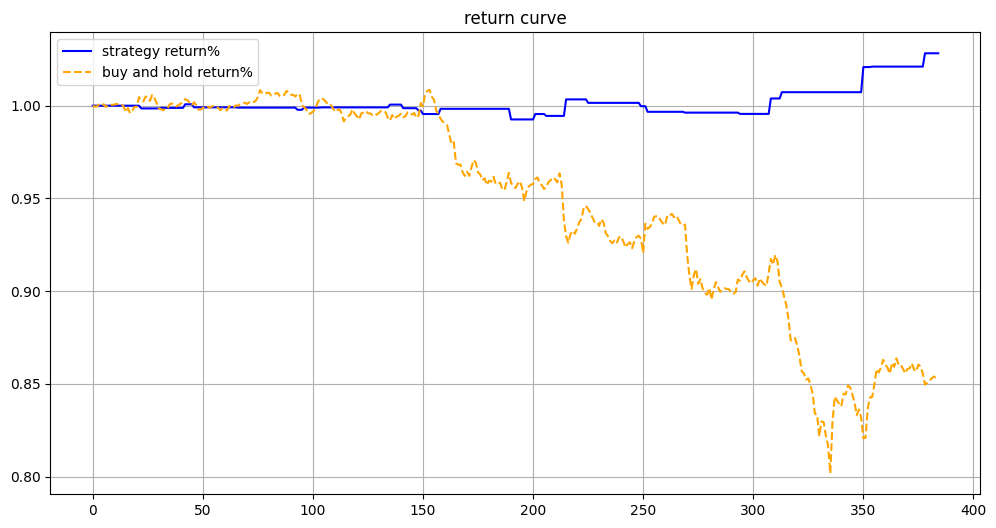

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設 kline 已有 'close' 和 'signal'

# 初始化倉位：1=多, -1=空, 0=平倉
positions = kline['signal'].shift(1).fillna(0)  # shift(1) 表示信號在下一根K線才生效

# 計算每日報酬率
returns = positions * kline['close'].pct_change().fillna(0)

# 計算累積報酬
cumulative_returns = (1 + returns).cumprod()

# 畫圖
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='strategy return%', color='blue')
plt.plot((1 + kline['close'].pct_change().fillna(0)).cumprod(), 
         label='buy and hold return%', color='orange', linestyle='--')
plt.title('return curve')
plt.legend()
plt.grid(True)
plt.show()

# topone退返70%報酬曲線

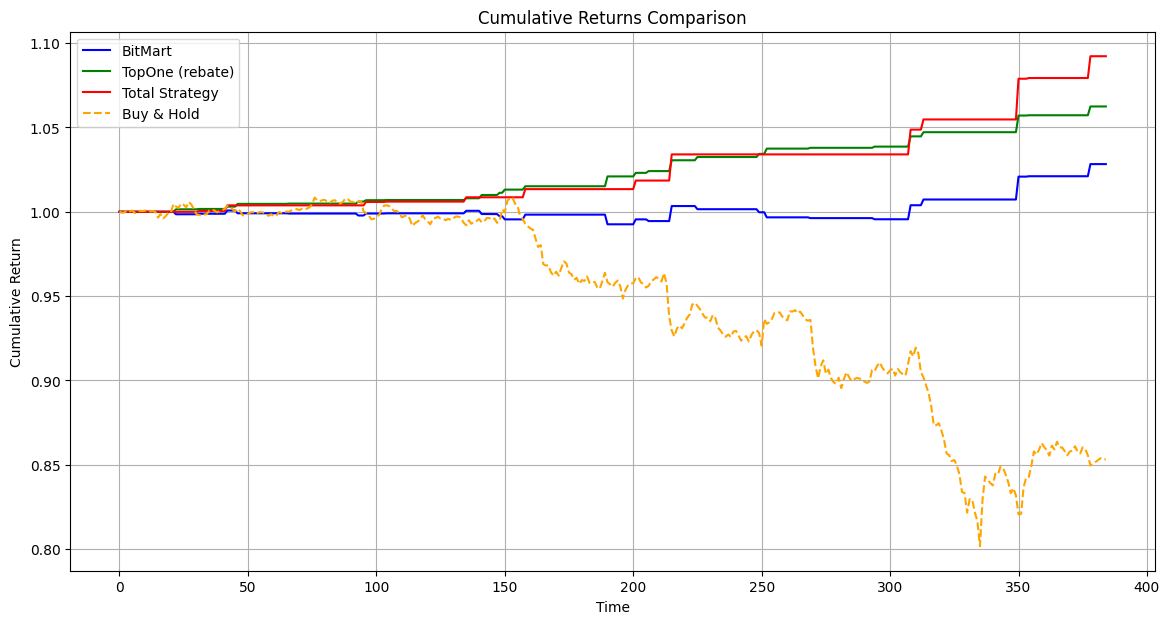

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設 kline 已有 'close' 和 'signal'
positions = kline['signal'].shift(1).fillna(0)

# BitMart 單純按照信號報酬
bitmart_returns = positions * kline['close'].pct_change().fillna(0)
cumulative_bitmart = (1 + pd.Series(bitmart_returns)).cumprod()

# TopOne 對沖單（反向）
topone_returns = -bitmart_returns.copy()
# TopOne 返還機制：虧損單返還 70%
topone_returns = np.where(topone_returns < 0, topone_returns * -0.7, topone_returns)
cumulative_topone = (1 + pd.Series(topone_returns)).cumprod()

# 總報酬
strategy_returns = bitmart_returns + topone_returns
cumulative_strategy = (1 + pd.Series(strategy_returns)).cumprod()

# Buy & Hold
cumulative_bh = (1 + kline['close'].pct_change().fillna(0)).cumprod()

# 畫圖
plt.figure(figsize=(14,7))
plt.plot(cumulative_bitmart, label='BitMart', color='blue')
plt.plot(cumulative_topone, label='TopOne (rebate)', color='green')
plt.plot(cumulative_strategy, label='Total Strategy', color='red')
plt.plot(cumulative_bh, label='Buy & Hold', color='orange', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


# 自動化交易

In [297]:
import time
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

symbol = 'ETHUSDT'
end_time = datetime.now()
start_time = end_time - timedelta(days=1)

while True:
    # 1️⃣ 取得最新 K 線
    kline = bitmart_client.get_kline_data('ETHUSDT', '15m', start_time, int(time.time()))
    
    # 2️⃣ 計算 Voger 信號
    signals = voger_plus_signals(kline)
    # 強制改成 1（測試用）
    signals.iloc[-1] = -1
    print("📈 訊號為:", signals.iloc[-1])
    
    # 3️⃣ 取得最新價格
    current_price = bitmart_client.get_current_price('ETHUSDT')
    print("💰 目前價格為:", current_price)

    # 預設止盈止損
    tp_price = current_price * 1.02  # 止盈 2%
    sl_price = current_price * 0.98  # 止損 2%

    # 4️⃣ 執行下單
    if signals.iloc[-1] == 1:
        print("🟢 嘗試開多單...")
        response = bitmart_client.place_order(
            'ETHUSDT',
            'long',
            margin=5,
            leverage=5,
            tp_price=current_price * 1.02,
            sl_price=current_price * 0.98
        )
    elif signals.iloc[-1] == -1:
        print("🔴 嘗試開空單...")
        response = bitmart_client.place_order(
            'ETHUSDT',
            'short',
            margin=5,
            leverage=5,
            tp_price=current_price * 0.98,
            sl_price=current_price * 1.02
        )
    else:
        print("⚪ 無明確信號，不下單。")
        break

    # 5️⃣ 驗證下單回傳結果
    print("📤 下單回應:", response)

    #取得倉位
    position = bitmart_client.get_position('ETHUSDT')
    print("📄 目前倉位:", position)
    
    time.sleep(10)    
    # 嘗試關倉
    response = bitmart_client.close_position('ETHUSDT')
    print("📤 關倉回應:", response)

    break

📈 訊號為: -1
💰 目前價格為: 3304.4049999999997
🔴 嘗試開空單...
📤 下單回應: ({'code': 1000, 'message': 'Ok', 'data': {'order_id': 3000237102979088, 'price': 'market price'}, 'trace': '13bfac97-ac0a-4b7f-8388-decf52c26aee'}, {'Remaining': '1', 'Limit': '24', 'Reset': '2', 'Mode': 'KEY'})
📄 目前倉位: {'symbol': 'ETHUSDT', 'leverage': '5', 'timestamp': 1762336426219, 'current_fee': '0.0000402', 'open_timestamp': 1762336426210, 'current_value': '23.13087', 'mark_price': '3304.4', 'position_value': '23.1308', 'position_cross': '4.642814176', 'maintenance_margin': '0.057827', 'close_vol': '0', 'close_avg_price': '0', 'open_avg_price': '3304.4', 'entry_price': '3304.4', 'current_amount': '7', 'unrealized_value': '-0.00007', 'realized_value': '-0.01387848', 'position_type': 2, 'margin_type': 'Isolated', 'mark_value': '23.1308', 'account': 'futures', 'position_mode': 'hedge_mode'}
📤 關倉回應: ({'code': 1000, 'message': 'Ok', 'data': {'order_id': 3000237110989502, 'price': 'market price'}, 'trace': '108153b4-024f-448b-ae6